# Steps
1. Import Training csv
2. Drop benign data
3. Setup autogluon
4. Train non persistent model
5. Test non persistent model
6. Check leaderboard
7. Check feature importance

# Imports 

In [1]:
import pandas as pd
from autogluon.tabular import TabularPredictor
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\zac\miniconda3\envs\navya\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import Training data

In [2]:

train_df = pd.read_csv("cic_ids_2017_train.csv")


In [3]:
train_df

,src_port,dst_port,src2dst_packets,dst2src_packets,src2dst_bytes,dst2src_bytes,src2dst_duration_ms,dst2src_duration_ms,src2dst_rst_packets,dst2src_rst_packets,...,bidirectional_psh_packets,bidirectional_ack_packets,bidirectional_urg_packets,bidirectional_cwr_packets,bidirectional_ece_packets,src2dst_psh_packets,dst2src_psh_packets,src2dst_urg_packets,dst2src_urg_packets,Label
0,53586,80,3,1,0,0,501,0,1,0,...,0,3,0,0,0,0,0,0,0,Portscan
1,60406,53,2,2,99,161,85374731,85375381,0,0,...,0,0,0,0,0,0,0,0,0,BENIGN
2,58864,80,8,6,414,11595,161992,149636,1,0,...,2,13,0,0,0,1,1,0,0,DoS Hulk
3,52186,21,11,17,108,188,10209325,10209249,0,2,...,14,25,0,0,0,7,7,0,0,FTP-Patator
4,56298,80,8,6,704,11595,371974,360760,2,0,...,3,11,0,0,0,2,1,0,0,DoS Hulk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34595,53674,21,11,17,128,188,9290170,9290144,0,2,...,14,25,0,0,0,7,7,0,0,FTP-Patator
34596,58198,80,14,3,2541,0,102642586,102642661,0,1,...,11,15,0,0,0,11,0,0,0,DoS Slowloris
34597,60731,53,1,1,80,208,0,0,0,0,...,0,0,0,0,0,0,0,0,0,BENIGN
34598,59624,21,11,17,116,188,8919913,8919859,0,2,...,14,25,0,0,0,7,7,0,0,FTP-Patator


# Drop Unused Labels

In [ ]:
# postscan overlaps with recon in persistent dataset, DDoS dont have a good way to test, botnet small dataset not good way to test.
unused = ['Infiltration - Portscan', 'Portscan', 'BENIGN']

train_df = train_df.loc[~train_df['Label'].isin(unused)]

<Axes: >

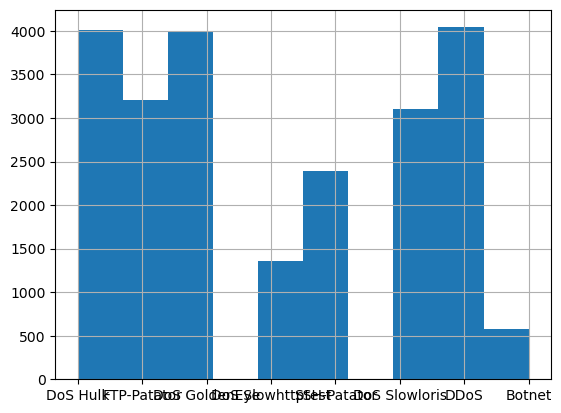

In [5]:
train_df['Label'].hist()

In [6]:
train_df['Label'].unique()

array(['DoS Hulk', 'FTP-Patator', 'DoS GoldenEye', 'DoS Slowhttptest',
       'SSH-Patator', 'DoS Slowloris', 'DDoS', 'Botnet'], dtype=object)

In [7]:
testbed_training = pd.read_csv('testbed_non_persistent_training.csv')

<Axes: >

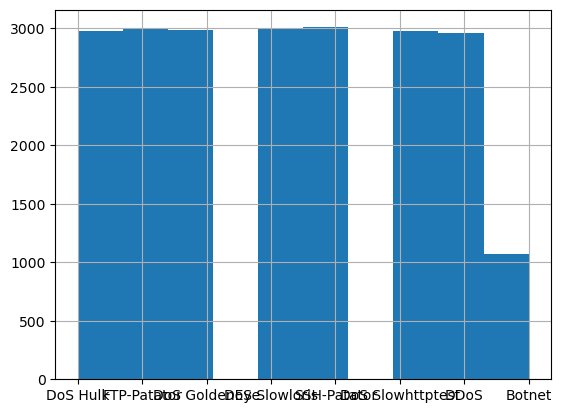

In [8]:
testbed_training['Label'].hist()

In [9]:
testbed_training['Label'].unique()

array(['DoS Hulk', 'FTP-Patator', 'DoS GoldenEye', 'DoS Slowloris',
       'SSH-Patator', 'DoS Slowhttptest', 'DDoS', 'Botnet'], dtype=object)

# Import CIC IDS test, remove unused labels

<Axes: >

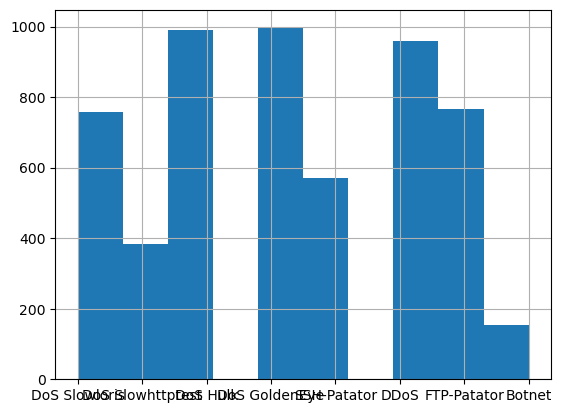

In [10]:
test_df = pd.read_csv('cic_ids_2017_test.csv')

# postscan overlaps with recon in persistent dataset.
unused = ['Infiltration - Portscan', 'Portscan', 'BENIGN']

test_df = test_df.loc[~test_df['Label'].isin(unused)]
test_df['Label'].hist()

# Testbed test df

In [11]:
testbed_testing = pd.read_csv('testbed_non_persistent_testing.csv')
testbed_testing['Label'].unique()

array(['DoS GoldenEye', 'SSH-Patator', 'DDoS', 'DoS Slowhttptest',
       'DoS Hulk', 'DoS Slowloris', 'FTP-Patator', 'Botnet'], dtype=object)

# Shuffle training data

In [12]:
train_df = train_df.sample(frac=1, random_state=29)
testbed_training = testbed_training.sample(frac=1, random_state=29)

# How much CIC IDS data is needed to train an accurate model?

In [13]:
stats = pd.DataFrame(columns=['train_rows', 'mcc', 'accuracy', 'balanced_accuracy', 'testbed_accuracy', 'best_model'])
for train_rows in range(2000, 18000, 2000):
    print(train_rows)
    predictor = TabularPredictor(label='Label', eval_metric= 'mcc').fit(presets='medium', train_data=train_df[:train_rows], fit_weighted_ensemble=False)
    evaluation = predictor.evaluate(test_df)
    leaderboard = predictor.leaderboard(test_df)

    evaluation_testbed = predictor.evaluate(testbed_testing)

    new_row = {'mcc': evaluation['mcc'], 'accuracy':evaluation['accuracy'], 'train_rows':train_rows, 'balanced_accuracy': evaluation['balanced_accuracy'], 'best_model': leaderboard.iloc[0]['model'], 'testbed_accuracy': evaluation_testbed['accuracy']}
    stats.loc[len(stats)] = new_row
    print(stats)

No path specified. Models will be saved in: "AutogluonModels\ag-20250710_050256"
Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          32
Memory Avail:       52.27 GB / 63.72 GB (82.0%)
Disk Space Avail:   685.48 GB / 1906.98 GB (35.9%)
Presets specified: ['medium']
Beginning AutoGluon training ...
AutoGluon will save models to "c:\Users\zac\Documents\github\modular_ids_framework\AutogluonModels\ag-20250710_050256"
Train Data Rows:    2000
Train Data Columns: 48
Label Column:       Label
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	8 unique label values:  ['FTP-Patator', 'SSH-Patator', 'DoS Slowhttptest', 'DoS Slowloris', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'Botnet']
	If 'multiclass' i

2000


		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 8): ['protocol', 'bidirectional_min_ps', 'dst2src_min_ps', 'bidirectional_urg_packets', 'bidirectional_cwr_packets', 'bidirectional_ece_packets', 'src2dst_urg_packets', 'dst2src_urg_packets']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 12 | ['bidirectional_mean_ps', 'bidirectional_stddev_ps', 'src2dst_mean_ps', 'src2dst_stddev_ps', 'dst2src_mean_ps', ...]
		('int', [])   : 28 | ['src_port', 'dst_port', 'src2dst_packets', 'dst2src_packets', 'src2dst_bytes', ...]
	Types of features in proce

   train_rows       mcc  accuracy  balanced_accuracy  testbed_accuracy  \
0        2000  0.997902  0.998209           0.997907          0.151759   

  best_model  
0   CatBoost  
4000


	0.9977	 = Validation score   (mcc)
	2.07s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9977	 = Validation score   (mcc)
	1.16s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9953	 = Validation score   (mcc)
	1.29s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9953	 = Validation score   (mcc)
	0.56s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9977	 = Validation score   (mcc)
	0.53s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	0.9977	 = Validation score   (mcc)
	105.55s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9977	 = Validation score   (mcc)
	0.48s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9977	 = Validation score   (mcc)
	0.46s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoo

   train_rows       mcc  accuracy  balanced_accuracy  testbed_accuracy  \
0        2000  0.997902  0.998209           0.997907          0.151759   
1        4000  0.999580  0.999642           0.999547          0.163175   

  best_model  
0   CatBoost  
1   CatBoost  
6000


	1.0	 = Validation score   (mcc)
	3.19s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMXT ...
	1.0	 = Validation score   (mcc)
	1.05s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	1.0	 = Validation score   (mcc)
	1.22s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	1.0	 = Validation score   (mcc)
	0.52s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	1.0	 = Validation score   (mcc)
	0.51s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	0.998	 = Validation score   (mcc)
	109.03s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	1.0	 = Validation score   (mcc)
	0.47s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	1.0	 = Validation score   (mcc)
	0.46s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ...
	1.0	 = Validati

   train_rows       mcc  accuracy  balanced_accuracy  testbed_accuracy  \
0        2000  0.997902  0.998209           0.997907          0.151759   
1        4000  0.999580  0.999642           0.999547          0.163175   
2        6000  0.998951  0.999104           0.999166          0.031158   

       best_model  
0        CatBoost  
1        CatBoost  
2  ExtraTreesEntr  
8000


	0.9985	 = Validation score   (mcc)
	4.15s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9985	 = Validation score   (mcc)
	1.19s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	1.0	 = Validation score   (mcc)
	1.28s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9985	 = Validation score   (mcc)
	0.54s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	1.0	 = Validation score   (mcc)
	0.54s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	0.9985	 = Validation score   (mcc)
	16.62s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	1.0	 = Validation score   (mcc)
	0.49s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	1.0	 = Validation score   (mcc)
	0.48s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ...
	1.0	 

   train_rows       mcc  accuracy  balanced_accuracy  testbed_accuracy  \
0        2000  0.997902  0.998209           0.997907          0.151759   
1        4000  0.999580  0.999642           0.999547          0.163175   
2        6000  0.998951  0.999104           0.999166          0.031158   
3        8000  0.999371  0.999463           0.999021          0.235563   

       best_model  
0        CatBoost  
1        CatBoost  
2  ExtraTreesEntr  
3  ExtraTreesEntr  
10000


	1.0	 = Validation score   (mcc)
	5.16s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMXT ...
	1.0	 = Validation score   (mcc)
	1.23s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBM ...
	1.0	 = Validation score   (mcc)
	1.3s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestGini ...
	1.0	 = Validation score   (mcc)
	0.57s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestEntr ...
	1.0	 = Validation score   (mcc)
	0.57s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	1.0	 = Validation score   (mcc)
	116.73s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	1.0	 = Validation score   (mcc)
	0.63s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	1.0	 = Validation score   (mcc)
	0.64s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: XGBoost ...
	1.0	 = Validation s

   train_rows       mcc  accuracy  balanced_accuracy  testbed_accuracy  \
0        2000  0.997902  0.998209           0.997907          0.151759   
1        4000  0.999580  0.999642           0.999547          0.163175   
2        6000  0.998951  0.999104           0.999166          0.031158   
3        8000  0.999371  0.999463           0.999021          0.235563   
4       10000  0.998323  0.998567           0.997928          0.219044   

       best_model  
0        CatBoost  
1        CatBoost  
2  ExtraTreesEntr  
3  ExtraTreesEntr  
4  ExtraTreesEntr  
12000


Metric mcc is not supported by this model - using log_loss instead
	1.0	 = Validation score   (mcc)
	8.46s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMXT ...
	1.0	 = Validation score   (mcc)
	1.39s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	1.0	 = Validation score   (mcc)
	1.51s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	1.0	 = Validation score   (mcc)
	0.67s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestEntr ...
	1.0	 = Validation score   (mcc)
	0.67s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ...
	1.0	 = Validation score   (mcc)
	119.68s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	1.0	 = Validation score   (mcc)
	0.52s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	1.0	 = Validation score   (mcc)
	0.51s	 = Training   runtime
	0.07s

   train_rows       mcc  accuracy  balanced_accuracy  testbed_accuracy  \
0        2000  0.997902  0.998209           0.997907          0.151759   
1        4000  0.999580  0.999642           0.999547          0.163175   
2        6000  0.998951  0.999104           0.999166          0.031158   
3        8000  0.999371  0.999463           0.999021          0.235563   
4       10000  0.998323  0.998567           0.997928          0.219044   
5       12000  0.999161  0.999283           0.998895          0.224550   

       best_model  
0        CatBoost  
1        CatBoost  
2  ExtraTreesEntr  
3  ExtraTreesEntr  
4  ExtraTreesEntr  
5        CatBoost  
14000


	0.01s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
	0.9966	 = Validation score   (mcc)
	7.19s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9983	 = Validation score   (mcc)
	1.24s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9983	 = Validation score   (mcc)
	1.4s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9992	 = Validation score   (mcc)
	0.59s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9983	 = Validation score   (mcc)
	0.62s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	0.9983	 = Validation score   (mcc)
	18.6s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9992	 = Validation score   (mcc)
	0.52s	 = Training   runtime
	0.05s	 = Validation 

   train_rows       mcc  accuracy  balanced_accuracy  testbed_accuracy  \
0        2000  0.997902  0.998209           0.997907          0.151759   
1        4000  0.999580  0.999642           0.999547          0.163175   
2        6000  0.998951  0.999104           0.999166          0.031158   
3        8000  0.999371  0.999463           0.999021          0.235563   
4       10000  0.998323  0.998567           0.997928          0.219044   
5       12000  0.999161  0.999283           0.998895          0.224550   
6       14000  0.999371  0.999463           0.999021          0.252350   

         best_model  
0          CatBoost  
1          CatBoost  
2    ExtraTreesEntr  
3    ExtraTreesEntr  
4    ExtraTreesEntr  
5          CatBoost  
6  RandomForestEntr  
16000


	0.9949	 = Validation score   (mcc)
	0.01s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
	1.0	 = Validation score   (mcc)
	8.27s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMXT ...
	1.0	 = Validation score   (mcc)
	1.24s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	1.0	 = Validation score   (mcc)
	1.34s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	1.0	 = Validation score   (mcc)
	0.61s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestEntr ...
	1.0	 = Validation score   (mcc)
	0.62s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	1.0	 = Validation score   (mcc)
	122.32s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	1.0	 = Validation score   (mcc)
	0.56s	 = Training   runtime
	0.0

   train_rows       mcc  accuracy  balanced_accuracy  testbed_accuracy  \
0        2000  0.997902  0.998209           0.997907          0.151759   
1        4000  0.999580  0.999642           0.999547          0.163175   
2        6000  0.998951  0.999104           0.999166          0.031158   
3        8000  0.999371  0.999463           0.999021          0.235563   
4       10000  0.998323  0.998567           0.997928          0.219044   
5       12000  0.999161  0.999283           0.998895          0.224550   
6       14000  0.999371  0.999463           0.999021          0.252350   
7       16000  0.999790  0.999821           0.999674          0.182246   

         best_model  
0          CatBoost  
1          CatBoost  
2    ExtraTreesEntr  
3    ExtraTreesEntr  
4    ExtraTreesEntr  
5          CatBoost  
6  RandomForestEntr  
7          CatBoost  


<Axes: xlabel='train_rows', ylabel='value'>

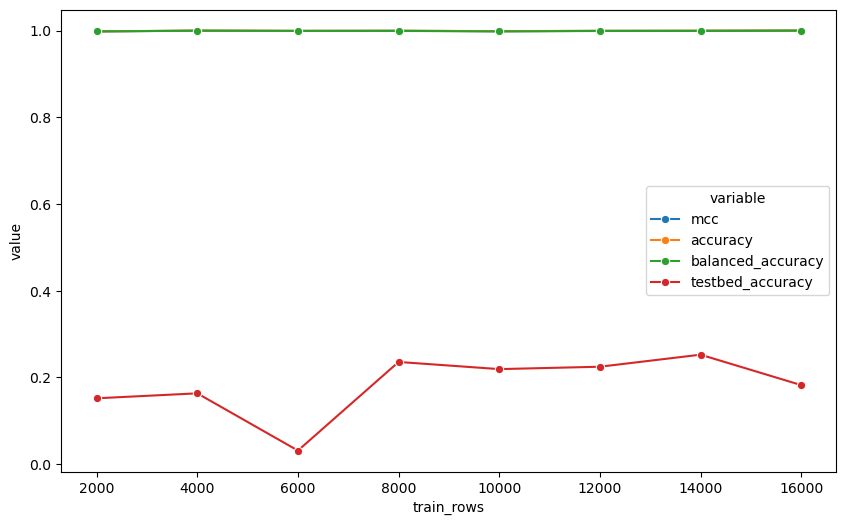

In [14]:
# Melt the DataFrame to have a long format for Seaborn lineplot
melted_stats = stats.melt(id_vars='train_rows',
                          value_vars=['mcc', 'accuracy', 'balanced_accuracy', 'testbed_accuracy'])

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_stats, x='train_rows', y='value', hue='variable', marker='o')

Autogluon trains a very accurate model for cic-ids dataset with very few rows. However, validating the model against out testbed data shows poor results. Interestingly, we see at train_rows 8000, we get a spike in the accuracy for the testbed validation data. We will use 8000 rows as the baseline amount of cic-ids data used.

In [15]:
stats = pd.DataFrame(columns=['train_rows', 'mcc_cic_ids', 'mcc_testbed', 'mcc_combined', 'best_model_combined'])
for train_rows in range(500, 4500, 500):
    merged_training_df = pd.concat([train_df[:8000], testbed_training[train_df.columns][:train_rows]])
    print(train_rows)
    print(len(merged_training_df))
    predictor = TabularPredictor(label='Label', eval_metric= 'mcc').fit(presets='medium', train_data=merged_training_df, fit_weighted_ensemble=False)
    
    evaluation_cic_ids = predictor.evaluate(test_df)
    evaluation_testbed = predictor.evaluate(testbed_testing)


    combined_leaderboard = predictor.leaderboard(pd.concat([testbed_testing, test_df]))
    combined_evaluation = predictor.evaluate(pd.concat([testbed_testing, test_df]))

    new_row = {'train_rows': train_rows, 'mcc_cic_ids':evaluation_cic_ids['mcc'], 'mcc_testbed':evaluation_testbed['mcc'], 'mcc_combined': combined_evaluation['mcc'], 'best_model_combined': combined_leaderboard.iloc[0]['model']}
    stats.loc[len(stats)] = new_row
    print(stats)

No path specified. Models will be saved in: "AutogluonModels\ag-20250710_052322"
Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          32
Memory Avail:       51.11 GB / 63.72 GB (80.2%)
Disk Space Avail:   684.95 GB / 1906.98 GB (35.9%)
Presets specified: ['medium']
Beginning AutoGluon training ...
AutoGluon will save models to "c:\Users\zac\Documents\github\modular_ids_framework\AutogluonModels\ag-20250710_052322"
Train Data Rows:    8500
Train Data Columns: 48
Label Column:       Label
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	8 unique label values:  ['FTP-Patator', 'SSH-Patator', 'DoS Slowhttptest', 'DoS Slowloris', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'Botnet']
	If 'multiclass' i

500
8500


	0.9904	 = Validation score   (mcc)
	4.44s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9917	 = Validation score   (mcc)
	1.71s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9931	 = Validation score   (mcc)
	1.58s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9903	 = Validation score   (mcc)
	0.55s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9903	 = Validation score   (mcc)
	0.56s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	0.9931	 = Validation score   (mcc)
	12.08s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9917	 = Validation score   (mcc)
	0.51s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9917	 = Validation score   (mcc)
	0.51s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost

   train_rows  mcc_cic_ids  mcc_testbed  mcc_combined best_model_combined
0         500     0.999371     0.952099      0.972232    RandomForestEntr
1000
9000


	0.9922	 = Validation score   (mcc)
	4.68s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9974	 = Validation score   (mcc)
	2.15s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9974	 = Validation score   (mcc)
	1.63s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9961	 = Validation score   (mcc)
	0.55s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9961	 = Validation score   (mcc)
	0.56s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	0.9948	 = Validation score   (mcc)
	14.15s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9961	 = Validation score   (mcc)
	0.49s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9961	 = Validation score   (mcc)
	0.5s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost 

   train_rows  mcc_cic_ids  mcc_testbed  mcc_combined best_model_combined
0         500     0.999371     0.952099      0.972232    RandomForestEntr
1        1000     0.999161     0.954929      0.973753    RandomForestEntr
1500
9500


No improvement since epoch 7: early stopping
	0.9779	 = Validation score   (mcc)
	4.63s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9926	 = Validation score   (mcc)
	1.76s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBM ...
	0.9914	 = Validation score   (mcc)
	1.58s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9902	 = Validation score   (mcc)
	0.56s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9914	 = Validation score   (mcc)
	0.57s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	0.9938	 = Validation score   (mcc)
	14.45s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9889	 = Validation score   (mcc)
	0.5s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9877	 = Validation score   (mcc)
	0.5s	 = Training   runtime
	0.04s	 =

   train_rows  mcc_cic_ids  mcc_testbed  mcc_combined best_model_combined
0         500     0.999371     0.952099      0.972232    RandomForestEntr
1        1000     0.999161     0.954929      0.973753    RandomForestEntr
2        1500     0.999790     0.960790      0.977387      ExtraTreesEntr
2000
10000


	0.9918	 = Validation score   (mcc)
	5.28s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9953	 = Validation score   (mcc)
	2.49s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.993	 = Validation score   (mcc)
	1.59s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.993	 = Validation score   (mcc)
	0.57s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9942	 = Validation score   (mcc)
	0.57s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	0.9942	 = Validation score   (mcc)
	13.77s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9953	 = Validation score   (mcc)
	0.5s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9953	 = Validation score   (mcc)
	0.51s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ..

   train_rows  mcc_cic_ids  mcc_testbed  mcc_combined best_model_combined
0         500     0.999371     0.952099      0.972232    RandomForestEntr
1        1000     0.999161     0.954929      0.973753    RandomForestEntr
2        1500     0.999790     0.960790      0.977387      ExtraTreesEntr
3        2000     0.999580     0.952477      0.972478       LightGBMLarge
2500
10500


	0.9867	 = Validation score   (mcc)
	5.45s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.99	 = Validation score   (mcc)
	2.31s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9956	 = Validation score   (mcc)
	1.69s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.99	 = Validation score   (mcc)
	0.57s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9911	 = Validation score   (mcc)
	0.58s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	0.99	 = Validation score   (mcc)
	14.95s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9922	 = Validation score   (mcc)
	0.51s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9911	 = Validation score   (mcc)
	0.5s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ...
	0

   train_rows  mcc_cic_ids  mcc_testbed  mcc_combined best_model_combined
0         500     0.999371     0.952099      0.972232    RandomForestEntr
1        1000     0.999161     0.954929      0.973753    RandomForestEntr
2        1500     0.999790     0.960790      0.977387      ExtraTreesEntr
3        2000     0.999580     0.952477      0.972478       LightGBMLarge
4        2500     0.999790     0.961685      0.977910             XGBoost
3000
11000


	0.01s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
Metric mcc is not supported by this model - using log_loss instead
	0.981	 = Validation score   (mcc)
	7.53s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9894	 = Validation score   (mcc)
	2.42s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9947	 = Validation score   (mcc)
	2.0s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9915	 = Validation score   (mcc)
	0.67s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9915	 = Validation score   (mcc)
	0.67s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ...
	0.9915	 = Validation score   (mcc)
	105.93s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9905	 = Validation score   (mcc)
	0.63s	 = Training   runtime
	0.06s	 = Validatio

   train_rows  mcc_cic_ids  mcc_testbed  mcc_combined best_model_combined
0         500     0.999371     0.952099      0.972232    RandomForestEntr
1        1000     0.999161     0.954929      0.973753    RandomForestEntr
2        1500     0.999790     0.960790      0.977387      ExtraTreesEntr
3        2000     0.999580     0.952477      0.972478       LightGBMLarge
4        2500     0.999790     0.961685      0.977910             XGBoost
5        3000     1.000000     0.966451      0.980742       LightGBMLarge
3500
11500


Metric mcc is not supported by this model - using log_loss instead
	0.9797	 = Validation score   (mcc)
	7.86s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9868	 = Validation score   (mcc)
	2.47s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	0.9909	 = Validation score   (mcc)
	1.9s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9879	 = Validation score   (mcc)
	0.68s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9879	 = Validation score   (mcc)
	0.68s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ...
	0.9889	 = Validation score   (mcc)
	17.14s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9889	 = Validation score   (mcc)
	0.63s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9858	 = Validation score   (mcc)
	0.63s	 = Train

   train_rows  mcc_cic_ids  mcc_testbed  mcc_combined best_model_combined
0         500     0.999371     0.952099      0.972232    RandomForestEntr
1        1000     0.999161     0.954929      0.973753    RandomForestEntr
2        1500     0.999790     0.960790      0.977387      ExtraTreesEntr
3        2000     0.999580     0.952477      0.972478       LightGBMLarge
4        2500     0.999790     0.961685      0.977910             XGBoost
5        3000     1.000000     0.966451      0.980742       LightGBMLarge
6        3500     0.999580     0.963690      0.978973            CatBoost
4000
12000


Metric mcc is not supported by this model - using log_loss instead
	0.9816	 = Validation score   (mcc)
	6.38s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMXT ...
	0.9864	 = Validation score   (mcc)
	3.4s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM ...
	0.9893	 = Validation score   (mcc)
	1.78s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9884	 = Validation score   (mcc)
	0.58s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9903	 = Validation score   (mcc)
	0.6s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ...
	0.9855	 = Validation score   (mcc)
	29.29s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9894	 = Validation score   (mcc)
	0.53s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9874	 = Validation score   (mcc)
	0.51s	 = Train

   train_rows  mcc_cic_ids  mcc_testbed  mcc_combined best_model_combined
0         500     0.999371     0.952099      0.972232    RandomForestEntr
1        1000     0.999161     0.954929      0.973753    RandomForestEntr
2        1500     0.999790     0.960790      0.977387      ExtraTreesEntr
3        2000     0.999580     0.952477      0.972478       LightGBMLarge
4        2500     0.999790     0.961685      0.977910             XGBoost
5        3000     1.000000     0.966451      0.980742       LightGBMLarge
6        3500     0.999580     0.963690      0.978973            CatBoost
7        4000     0.999371     0.965069      0.979680            CatBoost


<Axes: xlabel='train_rows', ylabel='value'>

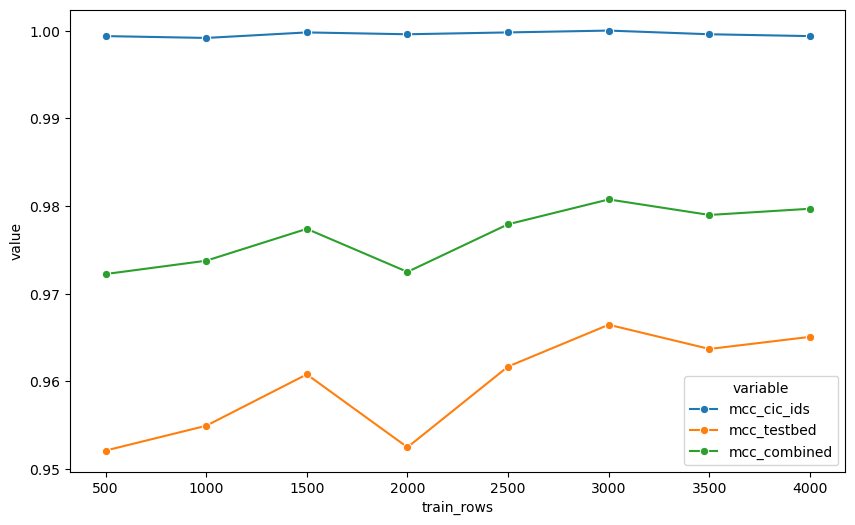

In [16]:
# Melt the DataFrame to have a long format for Seaborn lineplot
melted_stats = stats.melt(id_vars='train_rows',
                          value_vars=['mcc_cic_ids', 'mcc_testbed', 'mcc_combined'])

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_stats, x='train_rows', y='value', hue='variable', marker='o')

Only 3000 rows of testbed data needed to finetune the model. Testbed accuracy goes from from 40% -> 96%

In [17]:
stats

,train_rows,mcc_cic_ids,mcc_testbed,mcc_combined,best_model_combined
0,500,0.999371,0.952099,0.972232,RandomForestEntr
1,1000,0.999161,0.954929,0.973753,RandomForestEntr
2,1500,0.999790,0.960790,0.977387,ExtraTreesEntr
3,2000,0.999580,0.952477,0.972478,LightGBMLarge
4,2500,0.999790,0.961685,0.977910,XGBoost
5,3000,1.000000,0.966451,0.980742,LightGBMLarge
6,3500,0.999580,0.963690,0.978973,CatBoost
7,4000,0.999371,0.965069,0.979680,CatBoost


In [18]:
predictor.leaderboard(testbed_testing)


,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost,0.970625,0.985478,mcc,0.013739,0.010216,29.289703,0.013739,0.010216,29.289703,1,True,8
1,RandomForestEntr,0.969080,0.990314,mcc,0.065627,0.041759,0.598944,0.065627,0.041759,0.598944,1,True,7
2,ExtraTreesGini,0.968928,0.989352,mcc,0.067076,0.040557,0.530670,0.067076,0.040557,0.530670,1,True,9
3,RandomForestGini,0.968770,0.988385,mcc,0.077999,0.040709,0.582355,0.077999,0.040709,0.582355,1,True,6
4,ExtraTreesEntr,0.968464,0.987422,mcc,0.064213,0.047910,0.507356,0.064213,0.047910,0.507356,1,True,10
5,LightGBMXT,0.967840,0.986446,mcc,0.091743,0.016710,3.396664,0.091743,0.016710,3.396664,1,True,4
6,LightGBM,0.967402,0.989344,mcc,0.011834,0.000000,1.776388,0.011834,0.000000,1.776388,1,True,5
7,NeuralNetTorch,0.965069,0.991279,mcc,0.058044,0.017422,61.414447,0.058044,0.017422,61.414447,1,True,12
8,LightGBMLarge,0.964309,0.986433,mcc,0.004771,0.006804,4.367315,0.004771,0.006804,4.367315,1,True,13
9,XGBoost,0.964006,0.988380,mcc,0.071358,0.006757,1.902864,0.071358,0.006757,1.902864,1,True,11


In [19]:
merged_training_df = pd.concat([train_df[:8000], testbed_training[train_df.columns][:3000]])
predictor = TabularPredictor(label='Label', eval_metric= 'mcc').fit(presets='medium', train_data=merged_training_df, fit_weighted_ensemble=False)

No path specified. Models will be saved in: "AutogluonModels\ag-20250710_053700"
Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          32
Memory Avail:       50.93 GB / 63.72 GB (79.9%)
Disk Space Avail:   684.18 GB / 1906.98 GB (35.9%)
Presets specified: ['medium']
Beginning AutoGluon training ...
AutoGluon will save models to "c:\Users\zac\Documents\github\modular_ids_framework\AutogluonModels\ag-20250710_053700"
Train Data Rows:    11000
Train Data Columns: 48
Label Column:       Label
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	8 unique label values:  ['FTP-Patator', 'SSH-Patator', 'DoS Slowhttptest', 'DoS Slowloris', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'Botnet']
	If 'multiclass' 

In [20]:
predictor.evaluate(test_df)

{'mcc': np.float64(1.0), 'accuracy': 1.0, 'balanced_accuracy': np.float64(1.0)}

In [21]:
predictor.evaluate(testbed_testing)

{'mcc': np.float64(0.9664506831506222),
 'accuracy': 0.9708568358850389,
 'balanced_accuracy': np.float64(0.9693080816491892)}

In [22]:
predictor.leaderboard(pd.concat([test_df, testbed_testing]))

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge,0.981187,0.992589,mcc,0.061683,0.015444,4.431942,0.061683,0.015444,4.431942,1,True,13
1,XGBoost,0.980925,0.992586,mcc,0.110869,0.008006,2.070601,0.110869,0.008006,2.070601,1,True,11
2,CatBoost,0.980923,0.991528,mcc,0.039114,0.012059,97.980901,0.039114,0.012059,97.980901,1,True,8
3,LightGBM,0.980742,0.994709,mcc,0.018196,0.006502,1.806599,0.018196,0.006502,1.806599,1,True,5
4,ExtraTreesGini,0.979775,0.990469,mcc,0.086035,0.050527,0.513267,0.086035,0.050527,0.513267,1,True,9
5,ExtraTreesEntr,0.979422,0.992589,mcc,0.082914,0.039868,0.511375,0.082914,0.039868,0.511375,1,True,10
6,RandomForestEntr,0.979418,0.991529,mcc,0.068596,0.045877,0.582647,0.068596,0.045877,0.582647,1,True,7
7,RandomForestGini,0.979239,0.991532,mcc,0.096657,0.040573,0.567273,0.096657,0.040573,0.567273,1,True,6
8,LightGBMXT,0.978526,0.989421,mcc,0.087073,0.012526,2.315762,0.087073,0.012526,2.315762,1,True,4
9,NeuralNetTorch,0.973080,0.989427,mcc,0.104887,0.013656,18.464608,0.104887,0.013656,18.464608,1,True,12


In [23]:
# will return the path to the cloned predictor, identical to save_path_clone_opt
path_clone_opt = predictor.clone_for_deployment(path='non_persistent_model_finetune', model='LightGBMLarge')

Cloned TabularPredictor located in 'c:\Users\zac\Documents\github\modular_ids_framework\AutogluonModels\ag-20250710_053700' to 'non_persistent_model_finetune'.
	To load the cloned predictor: predictor_clone = TabularPredictor.load(path="non_persistent_model_finetune")
Clone: Keeping minimum set of models required to predict with model 'LightGBMLarge'...
Deleting model KNeighborsUnif. All files under c:\Users\zac\Documents\github\modular_ids_framework\non_persistent_model_finetune\models\KNeighborsUnif will be removed.
Deleting model KNeighborsDist. All files under c:\Users\zac\Documents\github\modular_ids_framework\non_persistent_model_finetune\models\KNeighborsDist will be removed.
Deleting model NeuralNetFastAI. All files under c:\Users\zac\Documents\github\modular_ids_framework\non_persistent_model_finetune\models\NeuralNetFastAI will be removed.
Deleting model LightGBMXT. All files under c:\Users\zac\Documents\github\modular_ids_framework\non_persistent_model_finetune\models\LightG

In [24]:
print('daintysquish <3')

daintysquish <3
